<a href="https://colab.research.google.com/github/DimpleB0501/AiDatasets/blob/master/DeepLearningwithPyTorch/transferLearningDatasetGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using github to import dataset in Colab

In [0]:
#Remove dataset if already available. Just do it once to see the whole procedure
!rm -rf AiDatasets

In [0]:
!git clone https://github.com/DimpleB0501/AiDatasets.git

Cloning into 'AiDatasets'...
remote: Enumerating objects: 25012, done.
remote: Counting objects: 100% (25012/25012), done.
remote: Compressing objects: 100% (25008/25008), done.
remote: Total 25012 (delta 2), reused 25012 (delta 2), pack-reused 0
Receiving objects: 100% (25012/25012), 541.49 MiB | 35.29 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (25010/25010), done.


In [0]:
!ls

AiDatasets  sample_data


# Transfer learning cats and dogs dataset

In [0]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
data_dir = '/content/drive/My Drive/AiScholarship/Cat_Dog_data/'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [0]:
print(len(train_data))
print(len(test_data))

22500
2500


In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 22747627.43it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
# Training 
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
torch.save(model, 'dogsNCatsTrain.pth')  

Epoch 1/1.. Train loss: 0.867.. Test loss: 0.411.. Test accuracy: 0.762
Epoch 1/1.. Train loss: 0.611.. Test loss: 0.346.. Test accuracy: 0.844
Epoch 1/1.. Train loss: 0.335.. Test loss: 0.145.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.300.. Test loss: 0.101.. Test accuracy: 0.977
Epoch 1/1.. Train loss: 0.253.. Test loss: 0.073.. Test accuracy: 0.980
Epoch 1/1.. Train loss: 0.172.. Test loss: 0.069.. Test accuracy: 0.978
Epoch 1/1.. Train loss: 0.172.. Test loss: 0.060.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.197.. Test loss: 0.055.. Test accuracy: 0.981
Epoch 1/1.. Train loss: 0.162.. Test loss: 0.051.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.162.. Test loss: 0.059.. Test accuracy: 0.977
Epoch 1/1.. Train loss: 0.127.. Test loss: 0.058.. Test accuracy: 0.978
Epoch 1/1.. Train loss: 0.230.. Test loss: 0.106.. Test accuracy: 0.962
Epoch 1/1.. Train loss: 0.294.. Test loss: 0.143.. Test accuracy: 0.941
Epoch 1/1.. Train loss: 0.237.. Test loss: 0.183.. Test accuracy

# Test the trained model on a random test image

In [0]:
device = 'cuda'
model=torch.load('dogsNCatsTrain.pth')
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
#Creating a label dictionary
labelDict = {0: 'Cat', 1: 'Dog' } 

tensor([[-5.0074, -0.0067]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
Dog


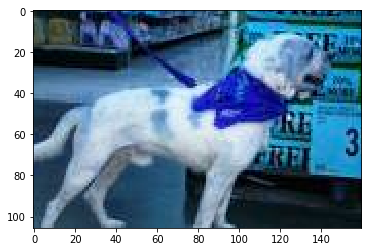

In [0]:
#Randomly selecting an image from a folder
import os, random
import cv2

value = random.choice([x for x in os.listdir('AiDatasets/Cat_Dog_data//randomTestImages') if os.path.isfile(os.path.join('AiDatasets/Cat_Dog_data//randomTestImages', x))])
imagePath  = 'AiDatasets/Cat_Dog_data//randomTestImages/'+str(value)
image = cv2.imread(imagePath, 1)
plt.imshow(image)


#loadedImg = torch.from_numpy(loadedImg)
from PIL import Image
ImageTransforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
image = Image.fromarray(image)
loadedImg = ImageTransforms(image) #Apply transforms to the loaded Image
loadedImg = loadedImg.unsqueeze(0) #Get it in proper dimension for the model
loadedImg = loadedImg.to(device)

out_predict = model(loadedImg)
print (out_predict)
pred = out_predict.max(1, keepdim=True)[1]
print (labelDict[pred.item()])